### Waves in the Steady State
#### Solving the Helmholtz Equation
For a wave which varies sinusoidally in time, the wave equation with a source term reduces to
$$\nabla^2 E + \frac{k^2}{n^2} E = S,$$
where $E$ and $S$ are vector fields representing the amplitude of the wave and the source, respectively. In the context of electromagnetic waves in the steady state, $E$ is the electric field, $k$ is the wavenumber and $n$ is the refractive index. This equation can be solved numerically on a grid by casting it into a matrix form. This is possible because the Helmholtz equation is linear.

In 2D, this equation can be written as
$$\frac{E_{i+1,j}+E_{i-1,j}-2E_{ij}}{\Delta x^2} + \frac{E_{i,j+1}+E_{i,j-1}-2E_{ij}}{\Delta y^2} + \frac{k^2}{n_{ij}^2} E_{ij} = S_{ij},$$
where $\Delta x$ and $\Delta y$ are the lengths and widths of the grid elements. In matrix form:
$$M_{ijkl} E_{kl} = S_{ij},$$
$$M_{ijkl} = \frac{\delta_{i+1,k}\delta_{jl}  +\delta_{i-1,k}\,\delta_{jl} - 2\delta_{ik}\delta_{jl}}{\Delta x^2} +   \frac{\delta_{ik}\delta_{j+1,l} + \delta_{ik}\delta_{j-1,l} - 2\delta_{ik}\delta_{jl}}{\Delta y^2} + \frac{k^2}{n_{ij}^2} \delta_{ik}\delta_{jl}$$

In [19]:
#NAME: Waves in the Steady State
#DESCRIPTION: Solving the Helmholtz equation to find the electric field strength in the steady state.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

#kronecker delta function
def kd(i,j):
    d = 0.0
    if i == j:
        d = 1.0
    return d

#the array is NxN
N = 101
#grid element length & width/m
D = 0.2
#wavelength of radiation/m
wavelength = 3.2
#wavenumber
wavenumber = 2*np.pi/wavelength

#refractive index array
n = np.ones((N,N), dtype = np.complex128)
for i in range(N):
    for j in range(N):
        if np.sqrt((D*(i-N/2))**2 + (D*(j-N/2))**2) > 8.0:
            n[i,j] = 2.2 - 0.1j

### Indexing
The above equation can be recast as 
$$\widetilde{M}_{pq} \widetilde{E}_{q} = \widetilde{S}_{p},$$
so that it can be solved simply by finding the inverse of the sparse matrix $\widetilde{M}$. The indexing scheme used to convert the $N \times N \times N \times N$ matrix $M$ to the $N^2 \times N^2$ matrix $\widetilde{M}$ is
$$\widetilde{M}_{Ni+j, Nk+l} = M_{ijkl},$$
$$\widetilde{E}_{Nk+l} = E_{kl},$$
but this is by no means unique! Careful investigation of $\widetilde{M}$ shows that it is a band matrix with $N$ upper and $N$ lower diagonals. The `scipy` library provides a function `scipy.linalg.solve_banded()` which can then be used to solve for the electric field. This function requires all of the non-zero elements of $\widetilde{M}$ to be stored in a $(2N+1) \times N^2$ matrix $B$ indexed as
$$B_{N+p-q,q} = \widetilde{M}_{pq}.$$

In [20]:
B = np.zeros((2*N+1,N*N), dtype = np.complex128)
for p in range(N*N):
    for q in range(p-N, p+N+1):
        if N*N > q and 0 <= q:
            i,j,k,l = int((p-(p%N))/N), int(p%N), int((q-(q%N))/N), int(q%N) #indices of the NxNxNxN array
            term1 = (1.0/D**2)*(kd(i+1,k)*kd(j,l)+kd(i-1,k)*kd(j,l)-2*kd(i,k)*kd(j,l))
            term2 = (1.0/D**2)*(kd(i,k)*kd(j+1,l)+kd(i,k)*kd(j-1,l)-2*kd(i,k)*kd(j,l))
            term3 = kd(i,k)*kd(j,l)*(wavenumber/n[i,j])**2
            B[N+p-q,q] = term1 + term2 + term3

Calculating $B$ takes awhile, but it's only a property of the 'room'. Once $B$ is known, the electric field for a range of sources can be found quickly!

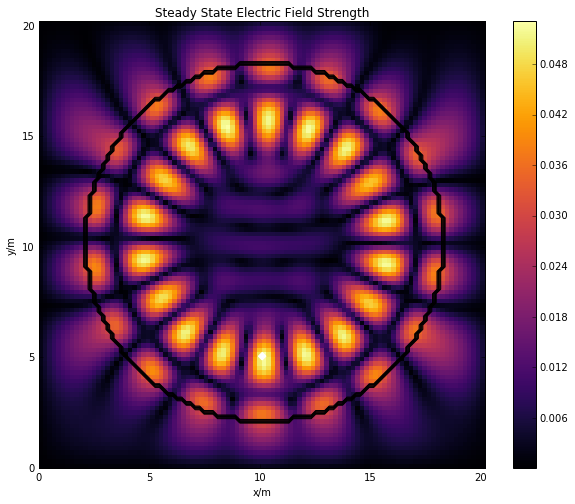

In [29]:
#create flattened source matrix            
Sf = np.zeros((N*N), dtype = np.complex128)
for i in range(N):
    for j in range(N):
        Sf[N*i+j] = kd(int(N/4),i)*kd(int(N/2),j)
        
#find flattened E matrix
Ef = la.solve_banded((N,N),B,Sf)

#unflatten E matrix
E = np.zeros((N,N), dtype = np.complex128)
S = np.zeros((N,N), dtype = np.complex128)
for i in range(N):
    for j in range(N):
        E[i,j] = Ef[N*i+j]
        S[i,j] = Sf[N*i+j]

#create x and y values for plot
x = np.linspace(0.0, D*N, N)
y = np.linspace(0.0, D*N, N)

#generate plot
plt.figure(figsize = (10,8))
plt.pcolor(x,y,np.absolute(E), cmap = "inferno")#, extent = (x.min(), x.max(), y.min(), y.max()), interpolation = 'none')
plt.colorbar()
#add black contours for refractive index
plt.contour(x,y, np.absolute(n), colors = 'k')
#add white contours for the source
plt.contour(x,y,np.absolute(S), colors = 'w')
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.title("Steady State Electric Field Strength")
plt.show()